In [1]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__, jwst.__file__)
from jwst.assign_wcs import nirspec
from jwst import datamodels

numpy version:  1.12.1
astropy version:  3.1.dev21681
asdf version:  2.0.0.dev1290
gwcs version:  0.9.dev332
jwst version:  0.9.3a.dev96 /internal/1/astropy/jwst/jwst/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
!/internal/1/astropy/jwst/scripts/strun assign_wcs.cfg nrs1_fs.fits

2018-04-16 10:15:13,341 - stpipe.assign_wcs - INFO - AssignWcsStep instance created.
2018-04-16 10:15:13,361 - stpipe.assign_wcs - INFO - Step assign_wcs running with args ('nrs1_fs.fits',).
2018-04-16 10:15:14,183 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.1260581910610199 deg
2018-04-16 10:15:14,183 - stpipe.assign_wcs - INFO - gwa_xtilt is 0.3316612243652344 deg
2018-04-16 10:15:14,184 - stpipe.assign_wcs - INFO - theta_y correction: 0.0002496099796717191 deg
2018-04-16 10:15:14,185 - stpipe.assign_wcs - INFO - theta_x correction: 0.0 deg
2018-04-16 10:15:14,822 - stpipe.assign_wcs - INFO - Removing slit S200B1 from the list of open slits because the WCS bounding_box is completely outside the detector.
2018-04-16 10:15:14,823 - stpipe.assign_wcs - INFO - Slits projected on detector NRS1: ['S200A1', 'S200A2', 'S400A1', 'S1600A1']
2018-04-16 10:15:14,823 - stpipe.assign_wcs - INFO - Computing WCS for 4 open slitlets
2018-04-16 10:15:14,868 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.

In [4]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/*.fits")
esa.remove("esa/Trace_SLIT_B_200_V84600010001P0000000002101_39547_JLAB88.fits")
map_slit_names = {'SLIT_A_1600' : 'S1600A1',
                  'SLIT_A_200_1': 'S200A1',
                  'SLIT_A_200_2': 'S200A2',
                  'SLIT_A_400':   'S400A1',
                  }

In [5]:
im = datamodels.ImageModel('nrs1_fs_assign_wcs.fits')

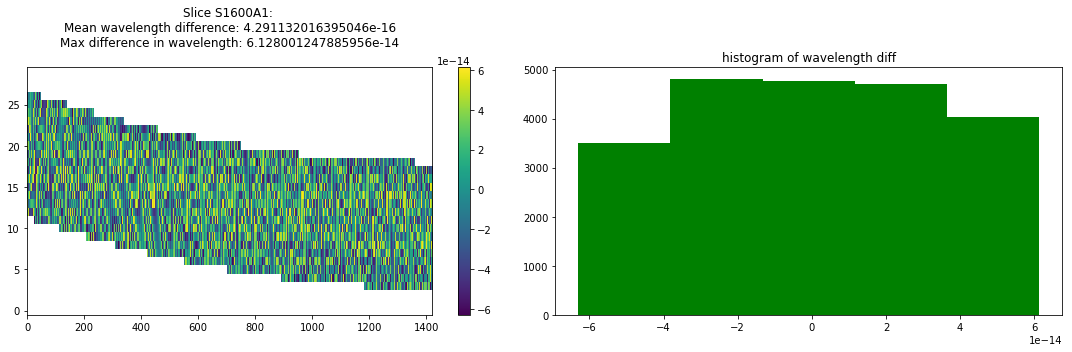

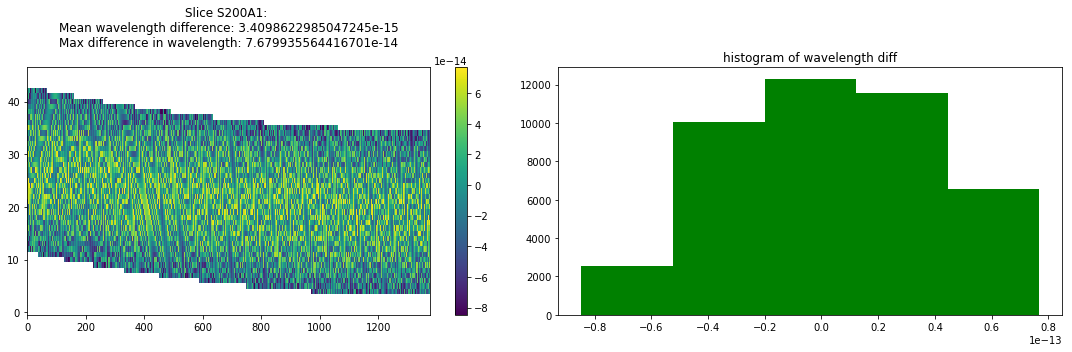

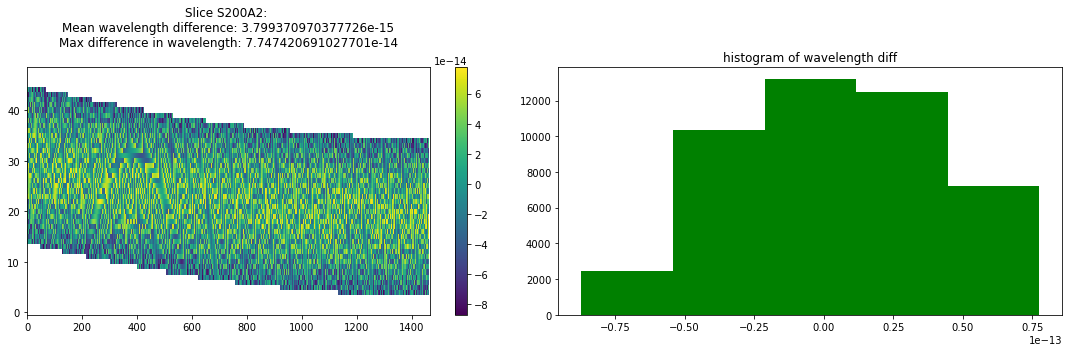

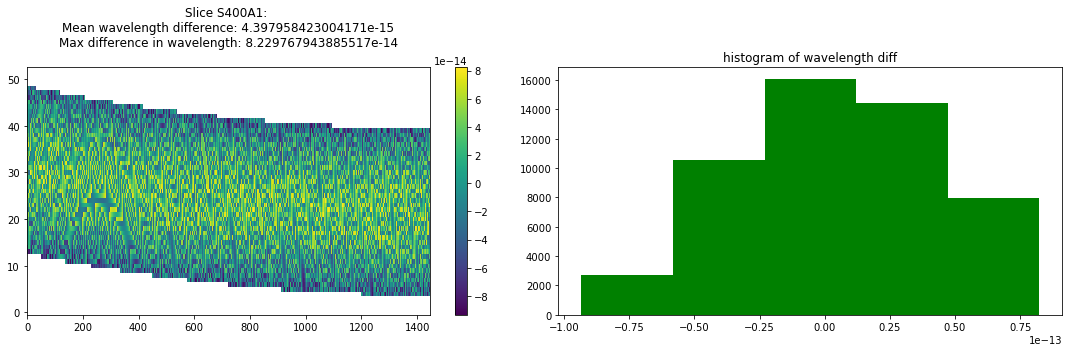

In [6]:
for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr[4].data
    slit1 = tr[5].data
    msay1 = tr[7].data
    pyw = wcs.WCS(tr[4].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    # Compute ra, dec and lambda
    ra, dec, lam = wcs_slice(x1-1, y1-1)
    lam *= 10**-6

    # For pixels where lam == NaN, set the value to -1
    notnan = ~np.isnan(lam)
    nanind = np.isnan(lam)
    lam[nanind] = np.nan
    lam1[nanind] = np.nan
    oneind = lam1 == np.nan
    lam[oneind] = np.nan

    # Compute the difference in wavelength
    diff = lam1 - lam
    title1 = "Slice {}: \n".format(slice_id)
    title1 += "Mean wavelength difference: {}\n".format(np.mean(diff[notnan]))
    title1 += "Max difference in wavelength: {}\n".format(np.max(diff[notnan]))
    
    title2 = "histogram of wavelength diff"
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diff, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diff[~np.isnan(diff)].flatten(), bins=5, color='green')
    plt.title(title2)

    fig.tight_layout()

In [7]:
from jwst import datamodels
from jwst.assign_wcs.nirspec import nrs_wcs_set_input

pipeline_file = "nrs1_fs_assign_wcs.fits"
im = datamodels.open(pipeline_file)
print("Working on exposure type {0}".format(im.meta.exposure.type))
print("grating: {0}".format(im.meta.instrument.grating))
print("filter: {0}".format(im.meta.instrument.filter))
print("GWA tilt correction:")
print("gwa_ytilt is 0.1260581910610199 deg")
print("gwa_xtilt is 0.3316612243652344 deg")
print("Final disperser THETA_Y angle is 0.12630780104069161 deg")

print("theta_x correction: 0.0 deg")
print("theta_y correction: {0} arcsec".format(0.0002496099796717191 * 3600))
print("Theta_y correction in Trace file is {0}".format(fits.getval(esa[0], "THETAY")))

Working on exposure type NRS_FIXEDSLIT
grating: G140M
filter: F100LP
GWA tilt correction:
gwa_ytilt is 0.1260581910610199 deg
gwa_xtilt is 0.3316612243652344 deg
Final disperser THETA_Y angle is 0.12630780104069161 deg
theta_x correction: 0.0 deg
theta_y correction: 0.8985959268181888 arcsec
Theta_y correction in Trace file is 0.8985959268181887


**Slit-y positions**

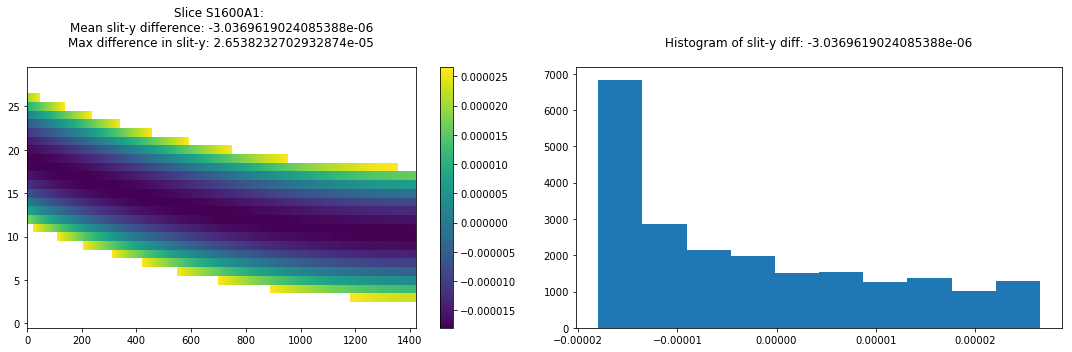

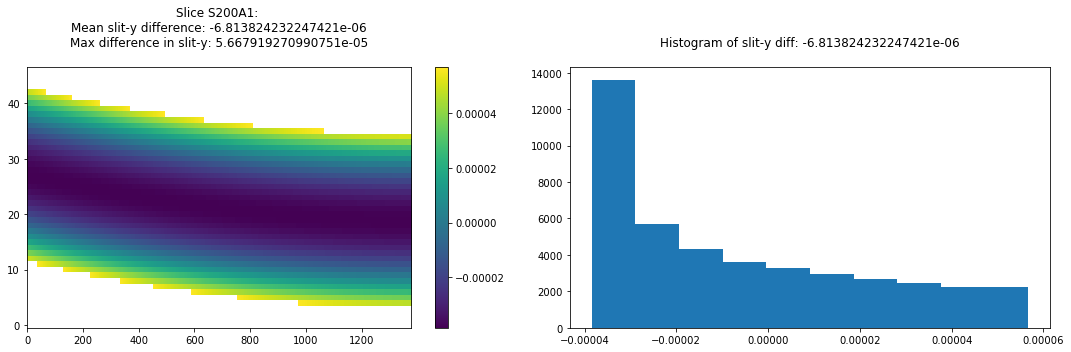

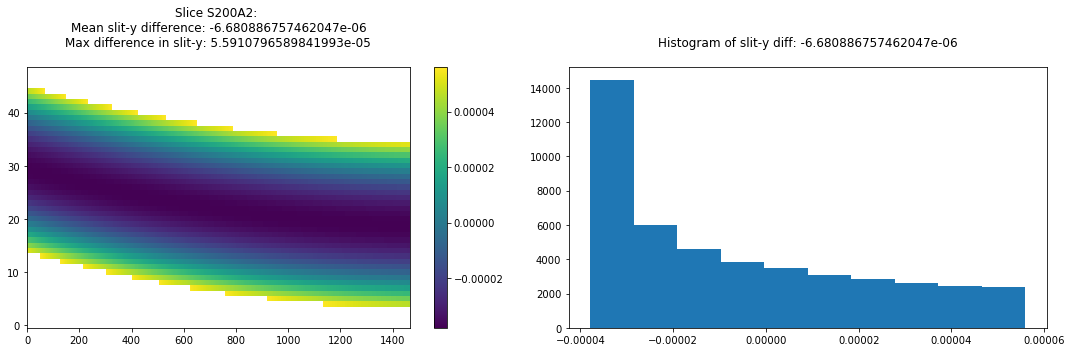

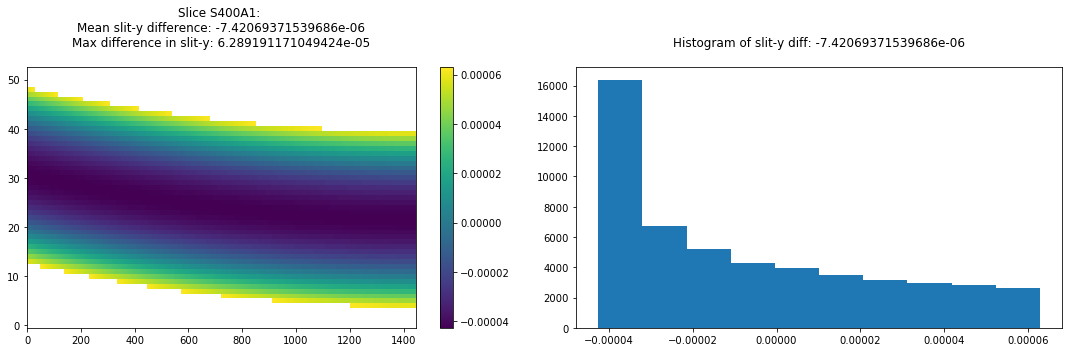

In [8]:
for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr[4].data
    slit1 = tr[5].data
    msay1 = tr[7].data
    pyw = wcs.WCS(tr[4].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, lam = detector2slit(x1-1, y1-1)
    # For pixels where lam == NaN, set the value to -1
    
    nanind = np.isnan(lam)
    oneind = lam1 == -1
    sy[nanind] = np.nan
    sy[oneind] = np.nan
    slit1[nanind] = np.nan
    slit1[oneind] = np.nan
    diffslit = sy - slit1
    notnan = ~np.isnan(slit1)
    
    # Plot differences and some statistics
    title1 = "Slice {}: \n".format(slice_id)
    title1 += "Mean slit-y difference: {}\n".format(np.mean(diffslit[notnan]))
    title1 += "Max difference in slit-y: {}\n".format(np.max(diffslit[notnan]))

    title2 = "Histogram of slit-y diff: {}\n".format(np.mean(diffslit[notnan]))
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffslit, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    ax2 = plt.subplot(1,2,2)
    i2 = ax2.hist(diffslit[notnan].flatten())
    plt.title(title2)

    fig.tight_layout()

### MSA_Y position

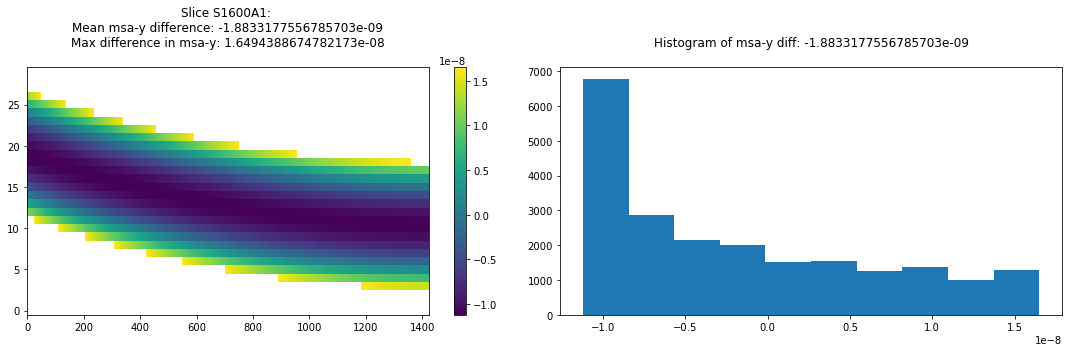

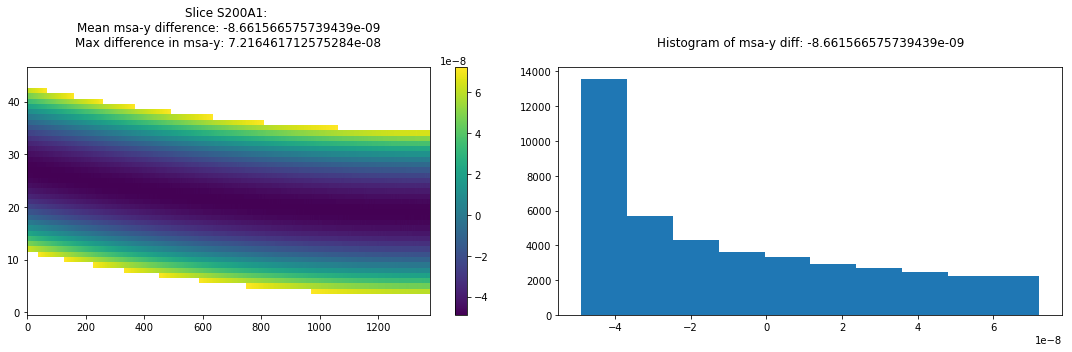

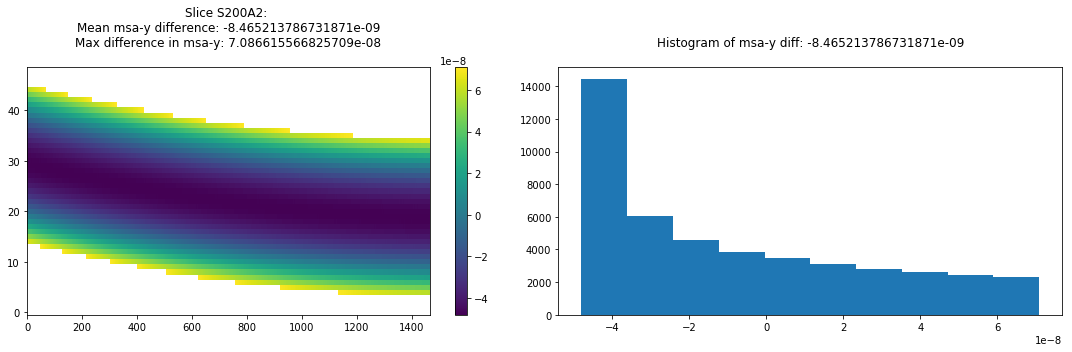

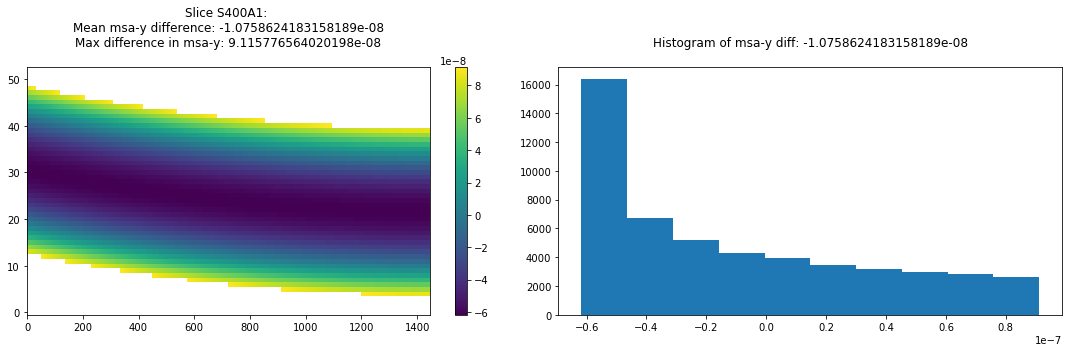

In [9]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    tr = fits.open(trace)
    lam1 = tr[4].data
    slit1 = tr[5].data
    msay1 = tr[7].data
    pyw = wcs.WCS(tr[4].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    
    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "msa_frame")
    mx, my, lam = detector2slit(x1-1, y1-1)
    # For pixels where lam == NaN, set the value to -1
    
    nanind = np.isnan(lam)
    oneind = lam1 == -1
    my[nanind] = np.nan
    my[oneind] = np.nan
    msay1[nanind] = np.nan
    msay1[oneind] = np.nan
    diffmsay = my - msay1
    notnan = ~np.isnan(my)
    # Plot differences and some statistics
    title1 = "Slice {}: \n".format(slice_id)
    title1 += "Mean msa-y difference: {}\n".format(np.mean(diffmsay[notnan]))
    title1 += "Max difference in msa-y: {}\n".format(np.max(diffmsay[notnan]))

    title2 = "Histogram of msa-y diff: {}\n".format(np.mean(diffmsay[notnan]))
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffmsay, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    
    ax2 = plt.subplot(1,2,2)
    i2 = ax2.hist(diffmsay[notnan].flatten())
    plt.title(title2)

    fig.tight_layout()